# Modulos necesarios proyecto final

In [1]:
# Imports
import sys
import os

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from kneed import KneeLocator
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import time
import logging
import joblib

# Path de los archivos del proyecto

In [15]:
in_spotify_dataset = './Source/tracks.csv'

data_scaled_pkl = './Data/data_scaled.pkl'
data_scaled_labeled_pkl = './Data/data_scaled_labeled.pkl'
data_train_pkl = './Data/data_train.pkl'
data_test_pkl = './Data/data_test.pkl'

model_kmeans_pkl = './Models/model_kmeans.pkl'

# Normalizacion de datos

In [11]:
# Process dataset
def clean_normalize_dataset(input_csv: str, scaled_output_pkl: str):

    start_time = time.time()
    print(f"Clean and Normalize Dataset")

    # Features
    old_features = ['energy','tempo','loudness','danceability','valence']
    new_features = ['arousal','valence']

    # Load the data and clean it (drop missing values)
    df = pd.read_csv(input_csv)
    print(f"Shape Original: {df.shape}")
    print(f"Missing data before cleanup: {df[old_features].isnull().sum().sum()} entries.")
    df = df[old_features].dropna().copy()
    print(f"Original Data Description:\n{df.describe()}")
    print(f"First few rows of the scaled data:\n{df.head()}")

    # Initialize the data_scaled DataFrame
    data_scaled = df.copy()

    # Define scaling ranges for specific features
    scale_ranges = {
        'tempo': (20, 200),
        'loudness': (-60, 0),
        'energy': (0, 1),
        'danceability': (0, 1)
    }

    # Clip the tempo and loudness values to ensure they stay within the expected ranges
    data_scaled['tempo'] = data_scaled['tempo'].clip(lower=20, upper=200)
    data_scaled['loudness'] = data_scaled['loudness'].clip(lower=-60, upper=0)
    data_scaled['energy'] = data_scaled['energy'].clip(lower=0, upper=1)
    data_scaled['danceability'] = data_scaled['danceability'].clip(lower=0, upper=1)

    # Apply MinMax scaling for each feature
    for feature, (min_input, max_input) in scale_ranges.items():
        min_output = 0
        max_output = 1
        data_scaled[feature] = (data_scaled[feature] - min_input) / (max_input - min_input) * (max_output - min_output) + min_output

    # Round the values to 3 decimal places
    data_scaled = data_scaled.round(3)

    # Log the description after scaling
    print(f"Scaled Data Description:\n{data_scaled.describe()}")

    # Define the weights for the features
    alpha = 0.5  # Energy has more influence on arousal
    beta = 0.25  # Tempo is still important, but less than energy
    gamma = 0.2  # Loudness is less important, but still relevant
    delta = 0.05  # Danceability plays the least role in arousal
    
    # Calculate the arousal score (weighted sum of selected features)
    data_scaled['arousal'] = (alpha * data_scaled['energy']) + \
                             (beta * data_scaled['tempo']) + \
                             (gamma * data_scaled['loudness']) + \
                             (delta * data_scaled['danceability'])
    
    # Round the values for arousal
    data_scaled = data_scaled.round(3)

    # Log the description after calculating arousal
    print(f"Data with Arousal Score Description:\n{data_scaled.describe()}")
    print(f"First few rows of the scaled data:\n{data_scaled.head()}")

    # Select the relevant columns (valence and arousal)
    scaled_df = data_scaled[new_features].dropna().copy()
    print(f"Shape Save: {df.shape}")

    # Save the cleaned and scaled DataFrame to a pickle file
    scaled_df.to_pickle(scaled_output_pkl)
    print(f"Scaled data saved to: {scaled_output_pkl}")

    print(f"Completed in {time.time() - start_time:.2f} seconds")

clean_normalize_dataset(in_spotify_dataset, data_scaled_pkl)

Clean and Normalize Dataset
Shape Original: (586672, 20)
Missing data before cleanup: 0 entries.
Original Data Description:
              energy          tempo       loudness   danceability  \
count  586672.000000  586672.000000  586672.000000  586672.000000   
mean        0.542036     118.464857     -10.206067       0.563594   
std         0.251923      29.764108       5.089328       0.166103   
min         0.000000       0.000000     -60.000000       0.000000   
25%         0.343000      95.600000     -12.891000       0.453000   
50%         0.549000     117.384000      -9.243000       0.577000   
75%         0.748000     136.321000      -6.482000       0.686000   
max         1.000000     246.381000       5.376000       0.991000   

             valence  
count  586672.000000  
mean        0.552292  
std         0.257671  
min         0.000000  
25%         0.346000  
50%         0.564000  
75%         0.769000  
max         1.000000  
First few rows of the scaled data:
   energy   

# Intentar entender cual es el numero de clusters ideal

Running Kmeans k = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] Clusters

Running K-Means for k=2


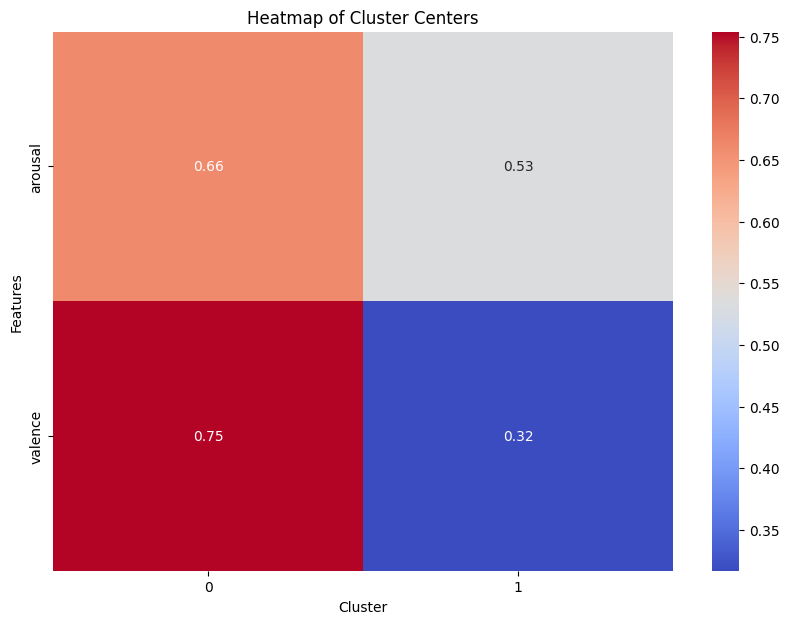

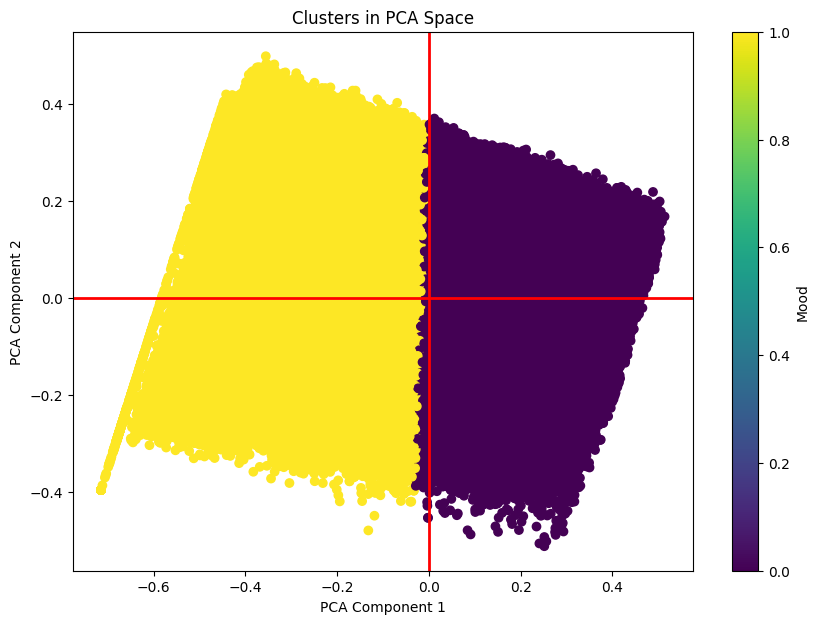

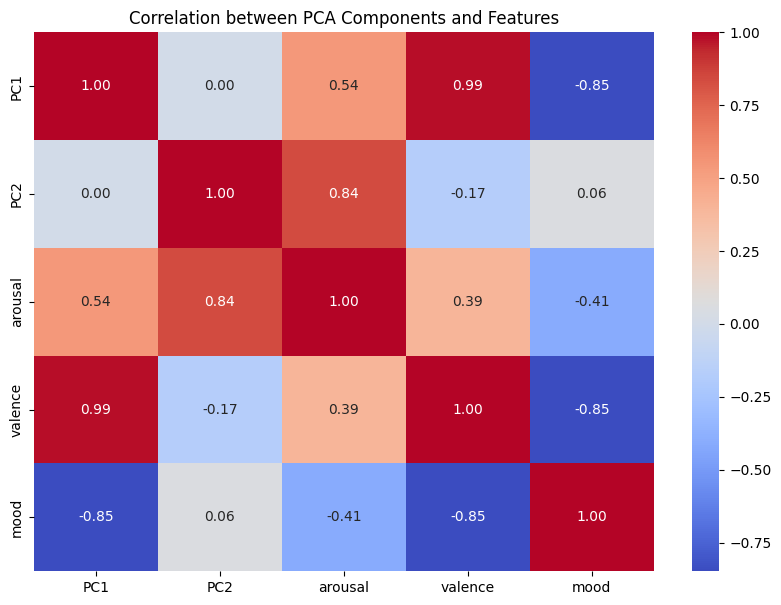

Completed K-Means for k=2 in 47.60 seconds


Running K-Means for k=3


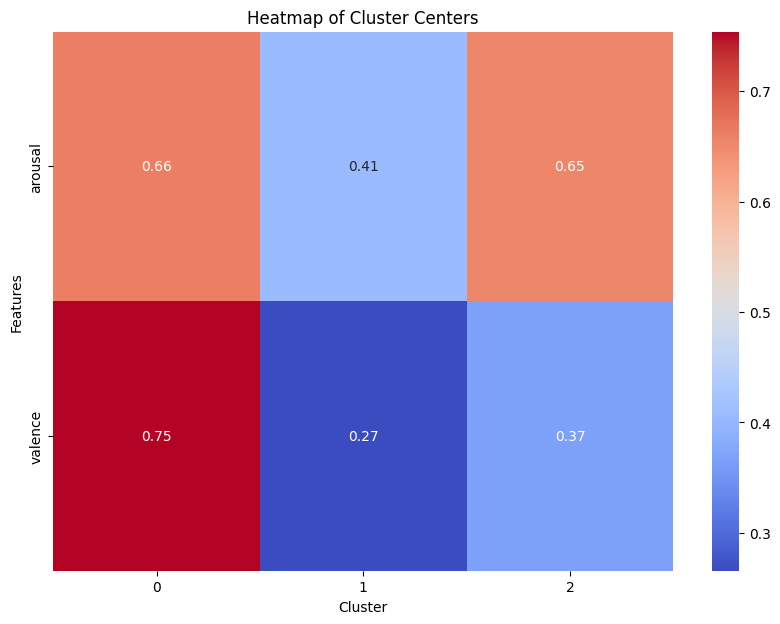

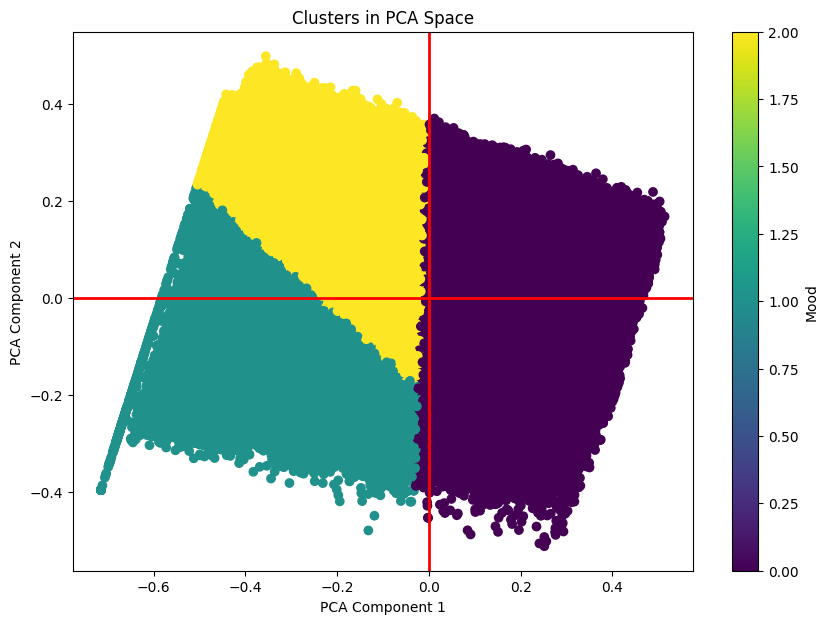

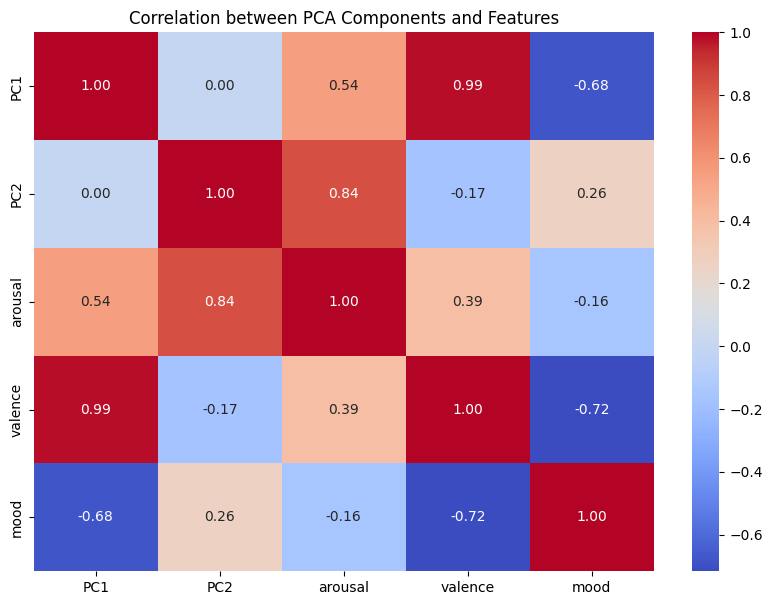

Completed K-Means for k=3 in 48.66 seconds


Running K-Means for k=4


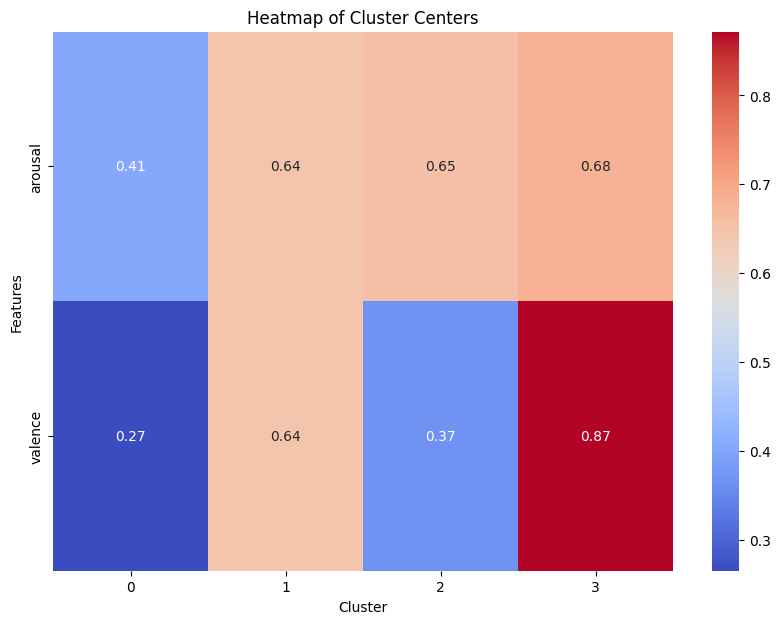

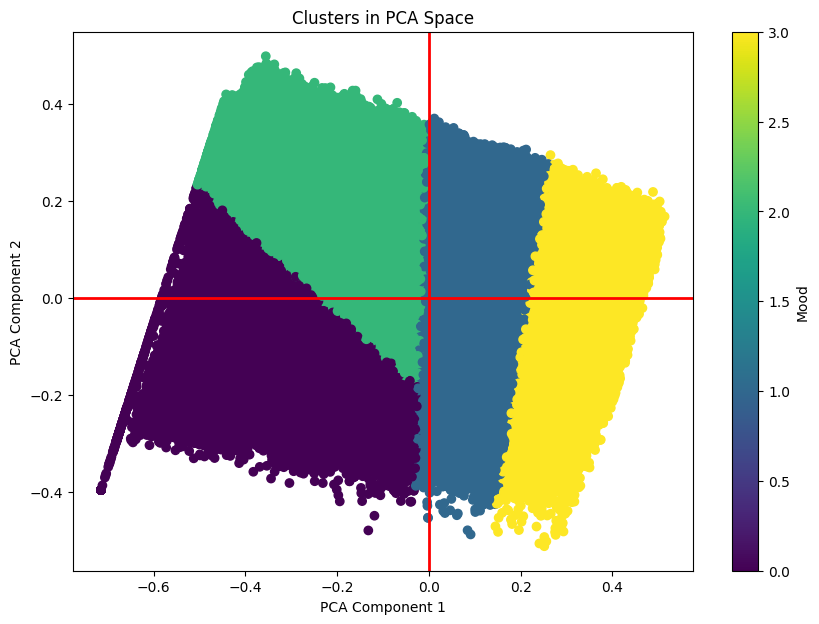

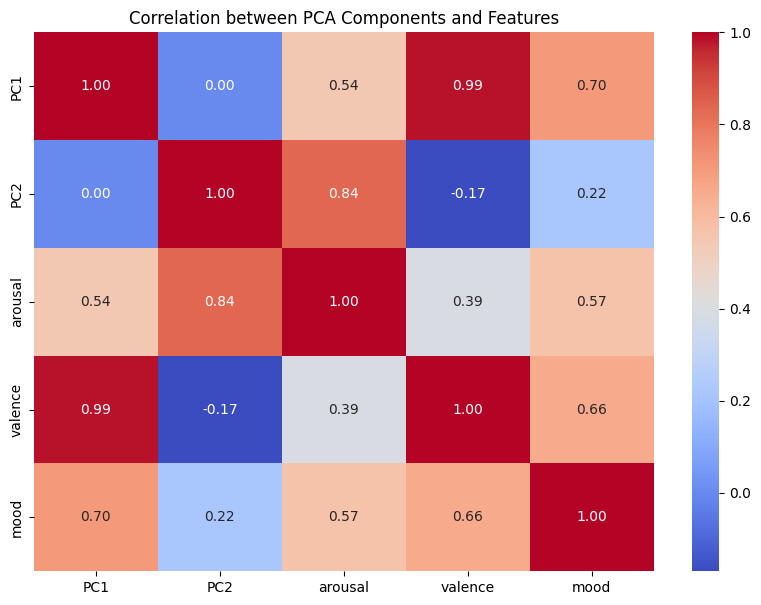

Completed K-Means for k=4 in 47.34 seconds


Running K-Means for k=5


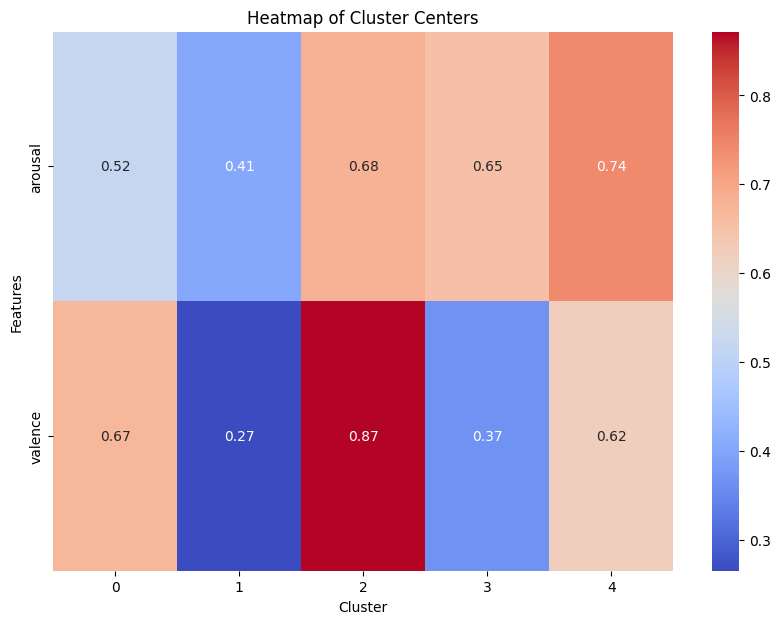

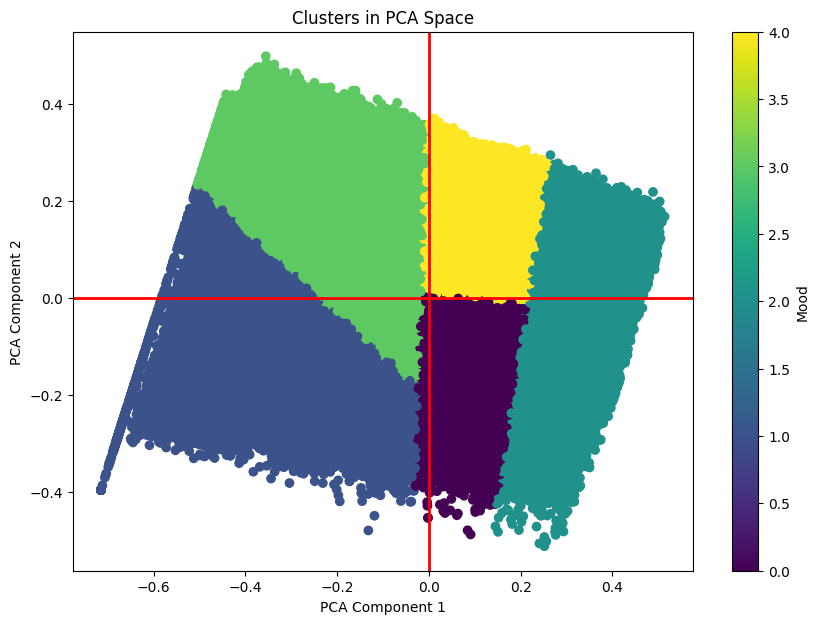

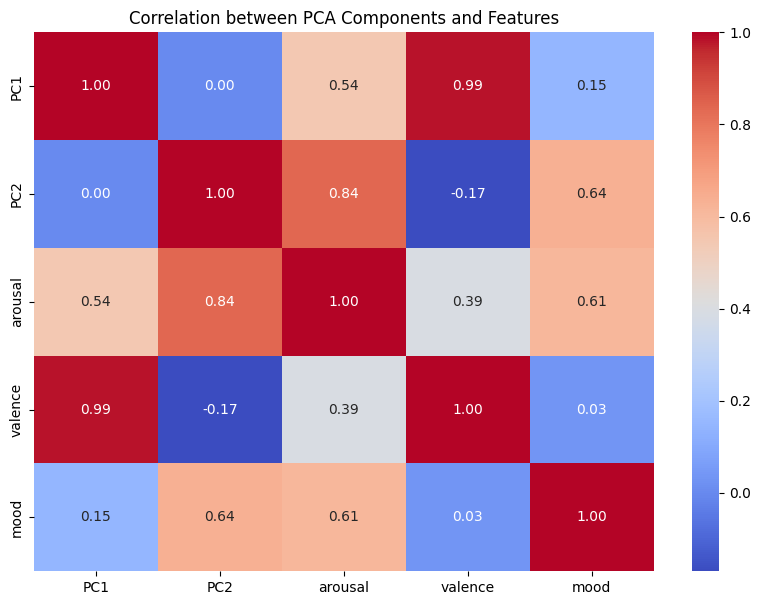

Completed K-Means for k=5 in 46.28 seconds


Running K-Means for k=6


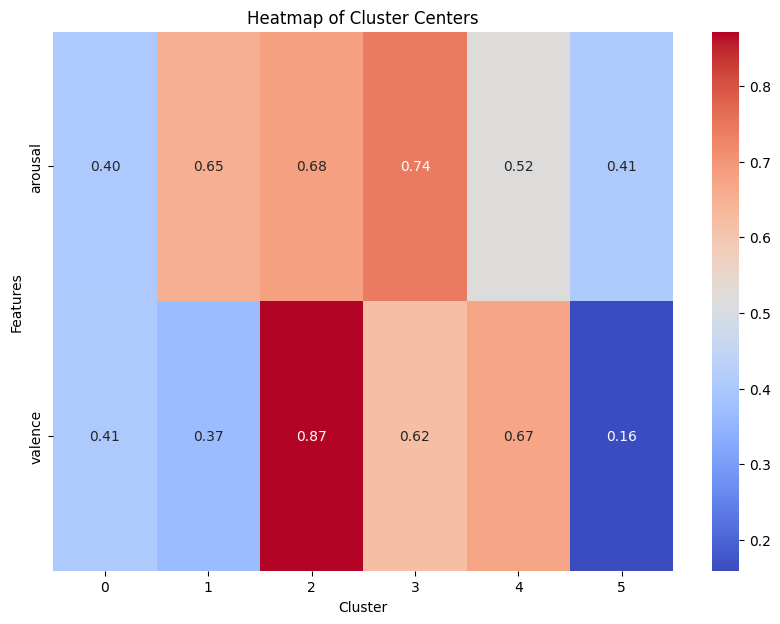

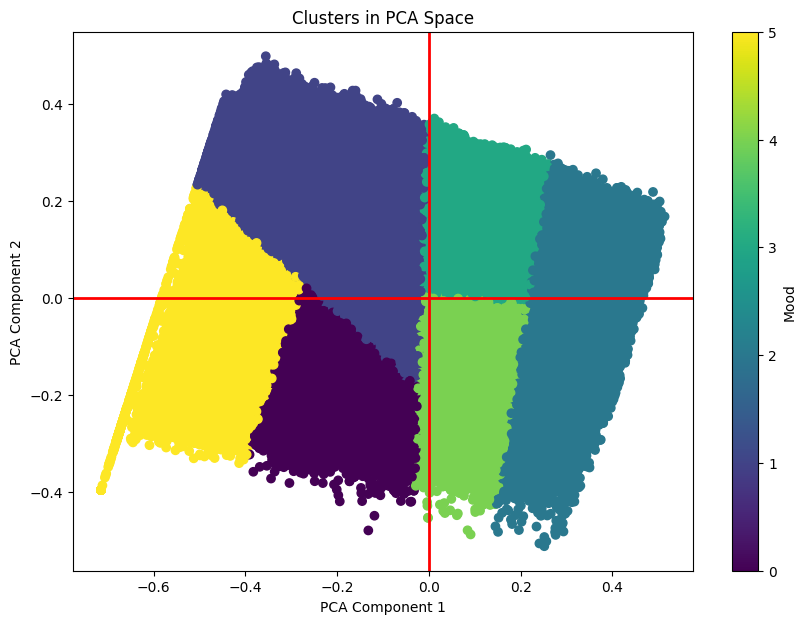

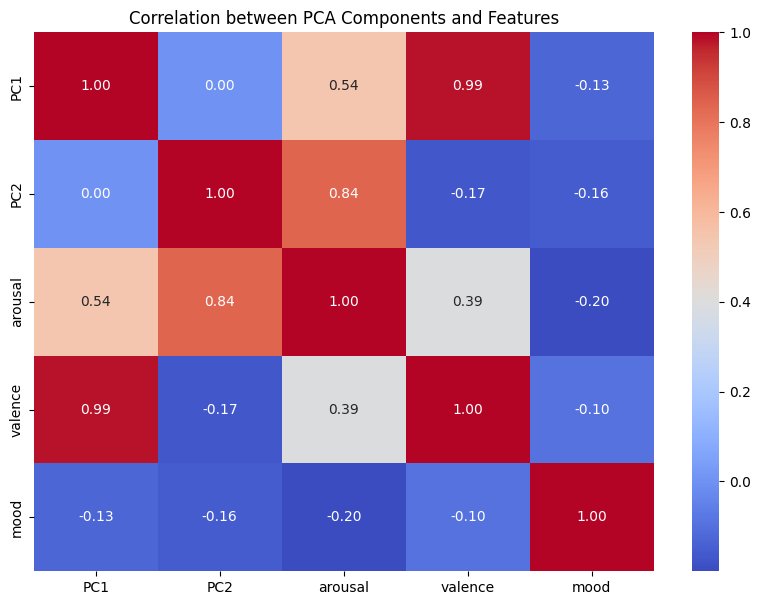

Completed K-Means for k=6 in 49.11 seconds


Running K-Means for k=7


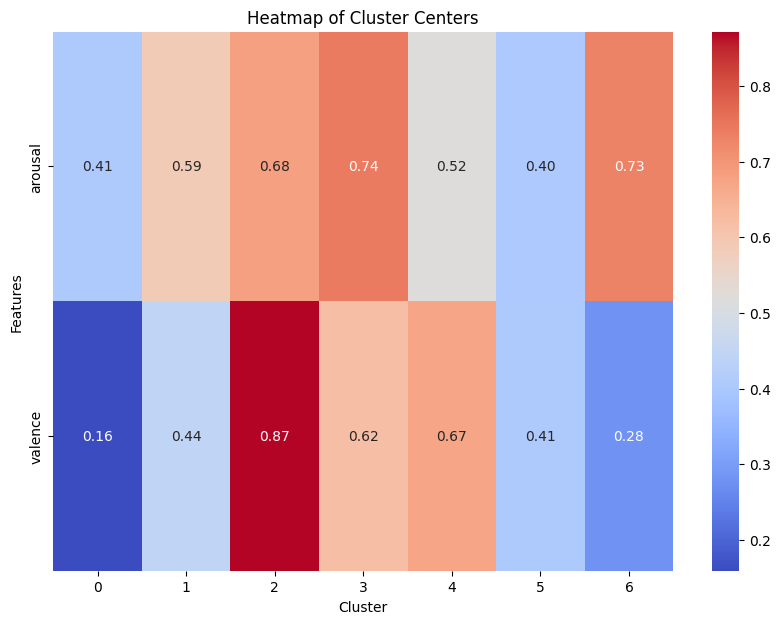

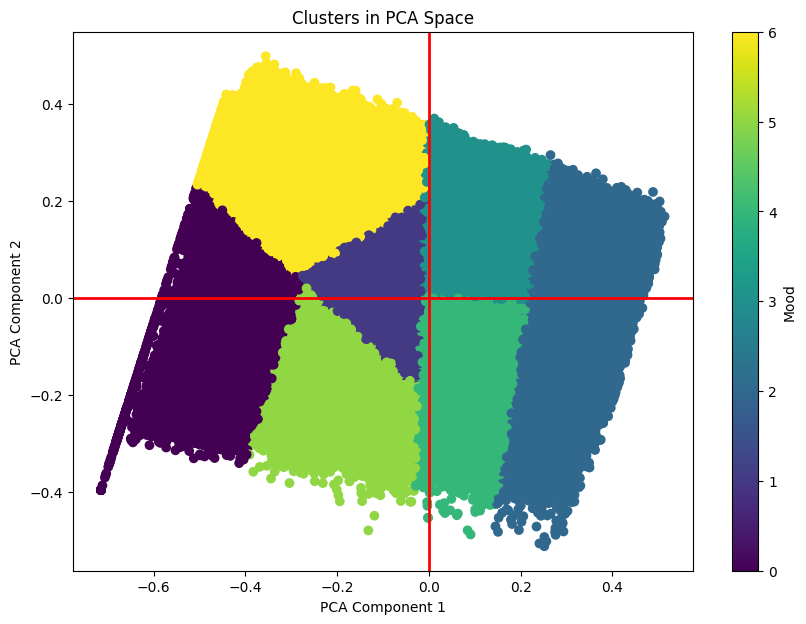

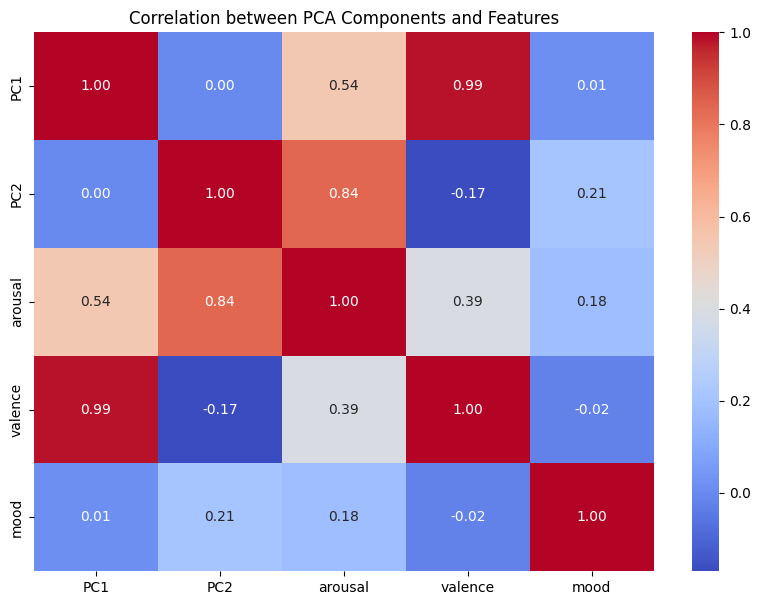

Completed K-Means for k=7 in 48.97 seconds


Running K-Means for k=8


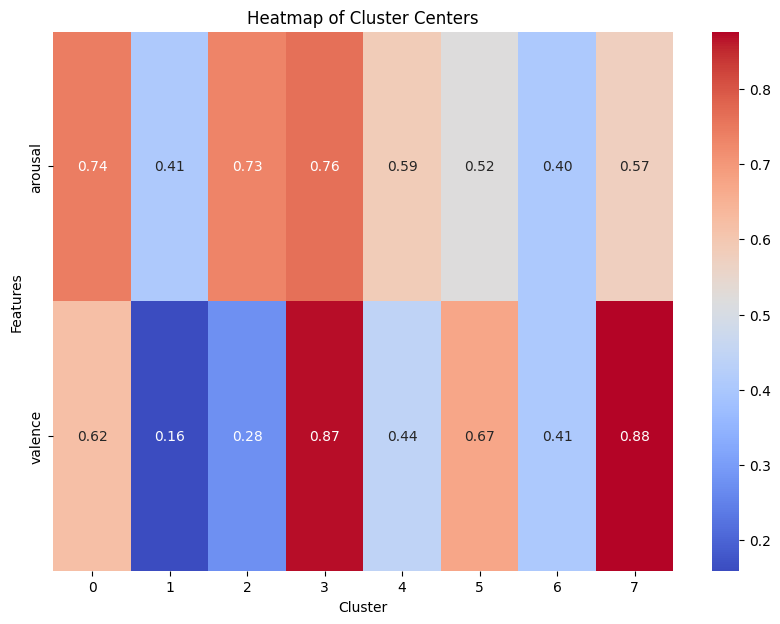

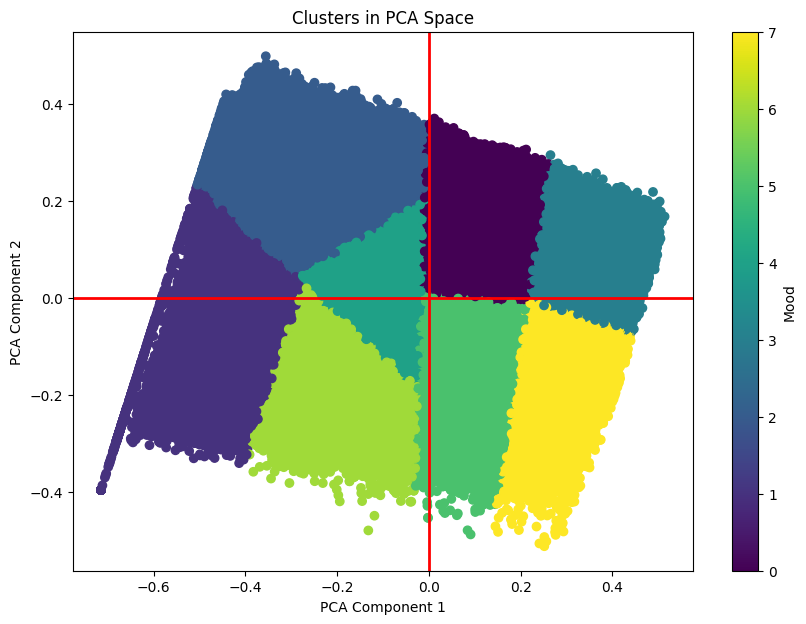

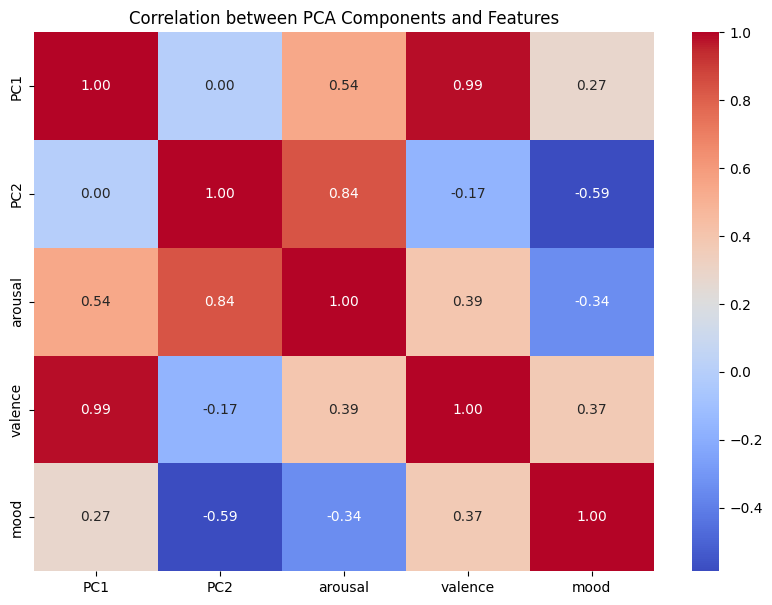

Completed K-Means for k=8 in 47.23 seconds


Running K-Means for k=9


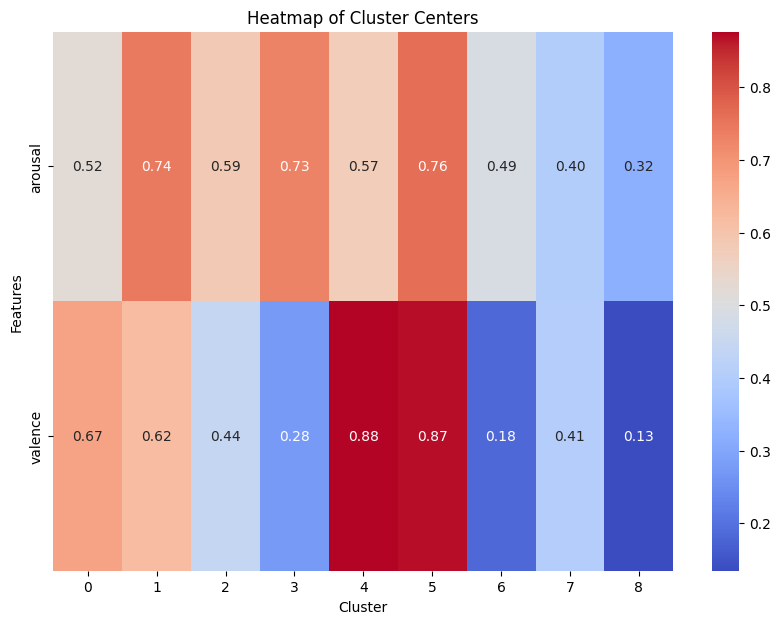

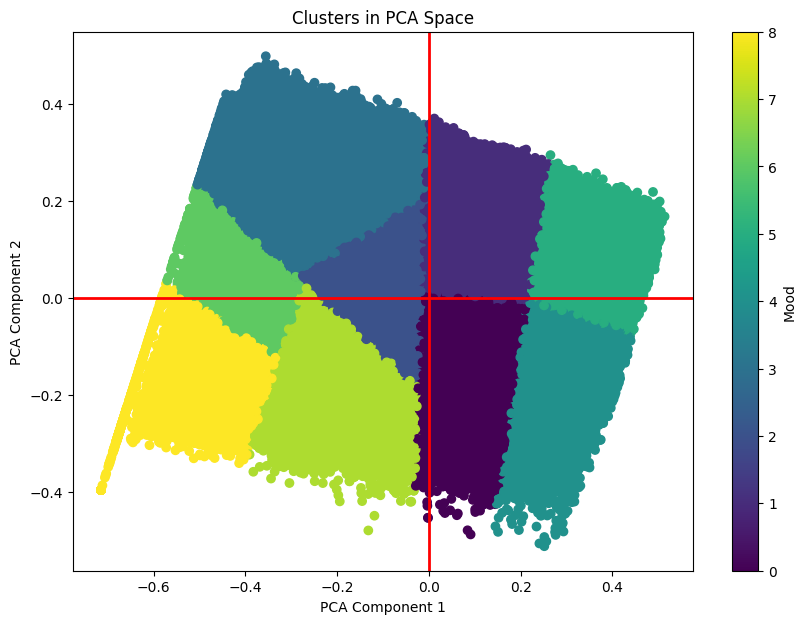

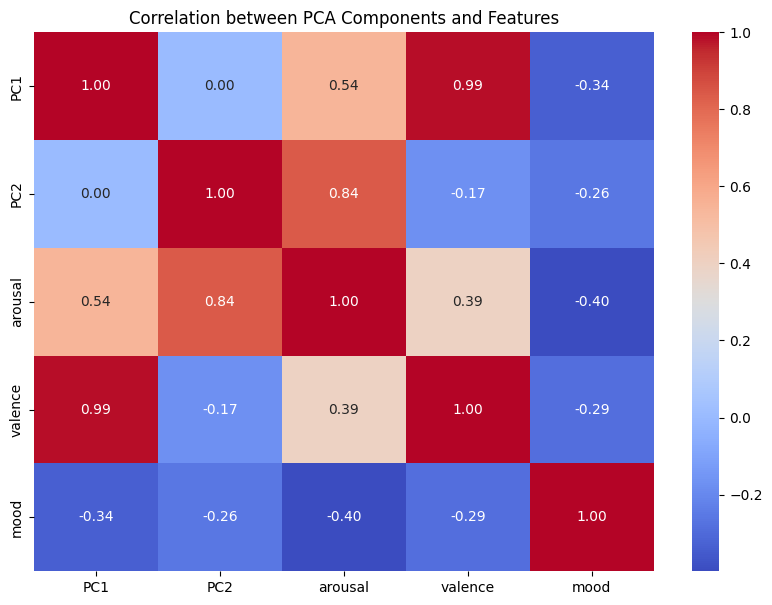

Completed K-Means for k=9 in 47.29 seconds


Running K-Means for k=10


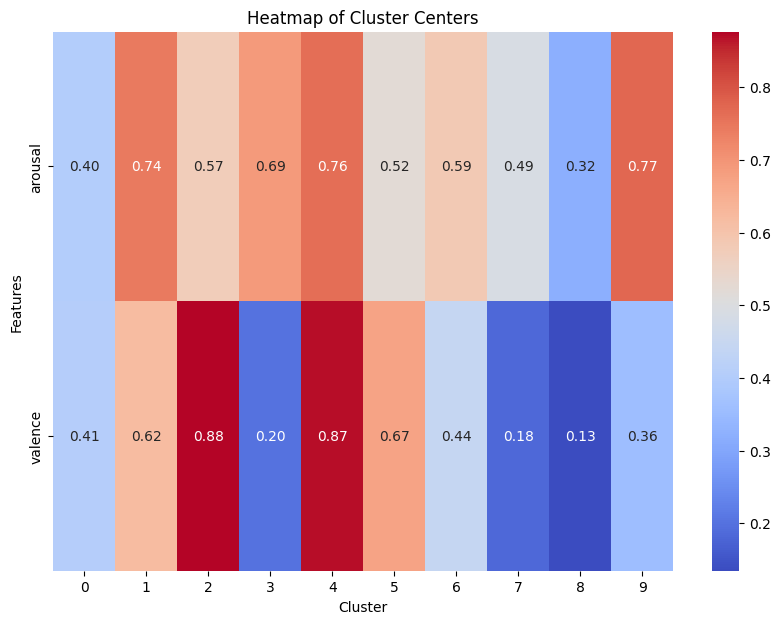

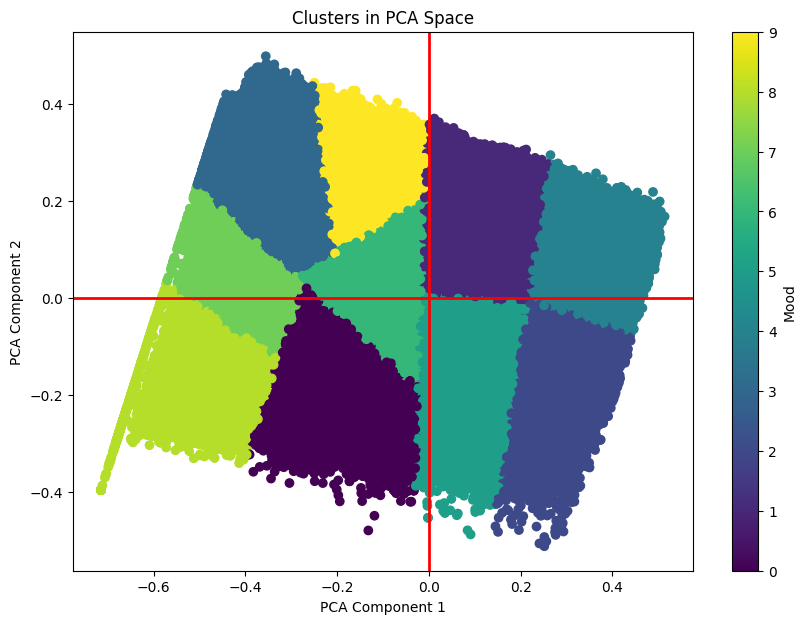

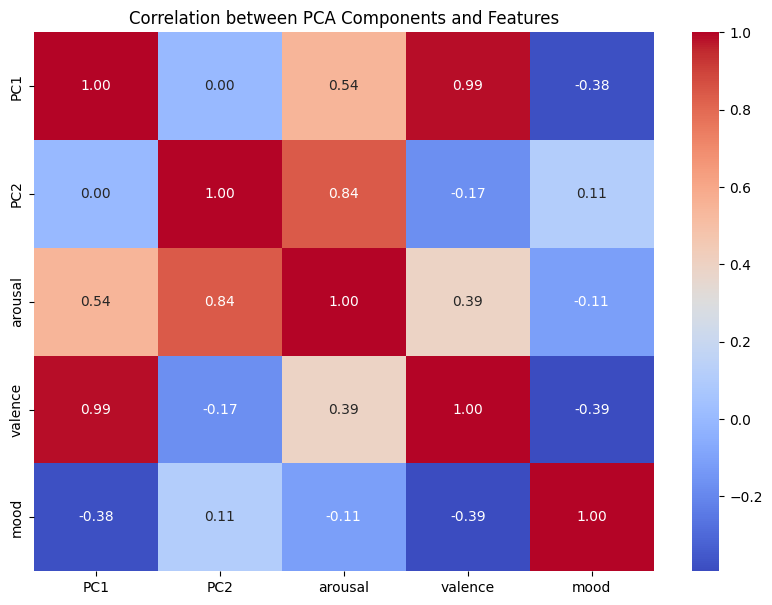

Completed K-Means for k=10 in 47.95 seconds


Running K-Means for k=11


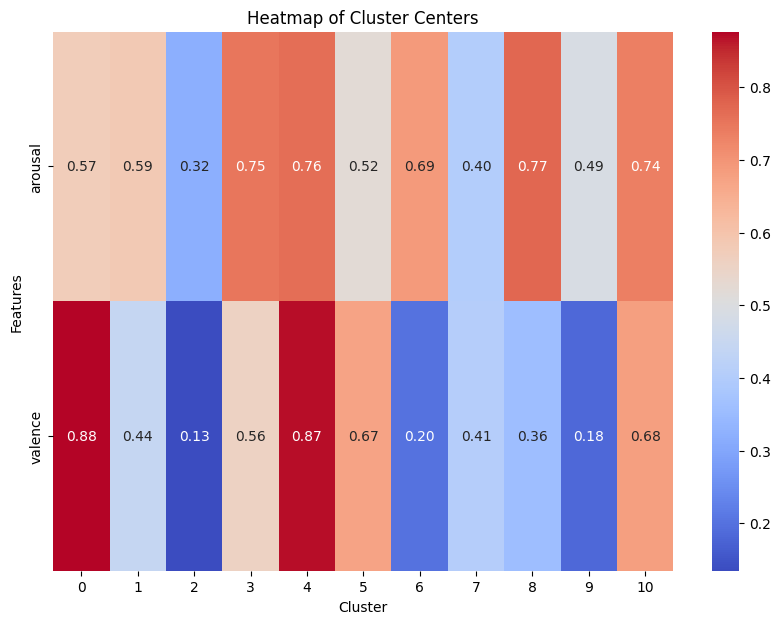

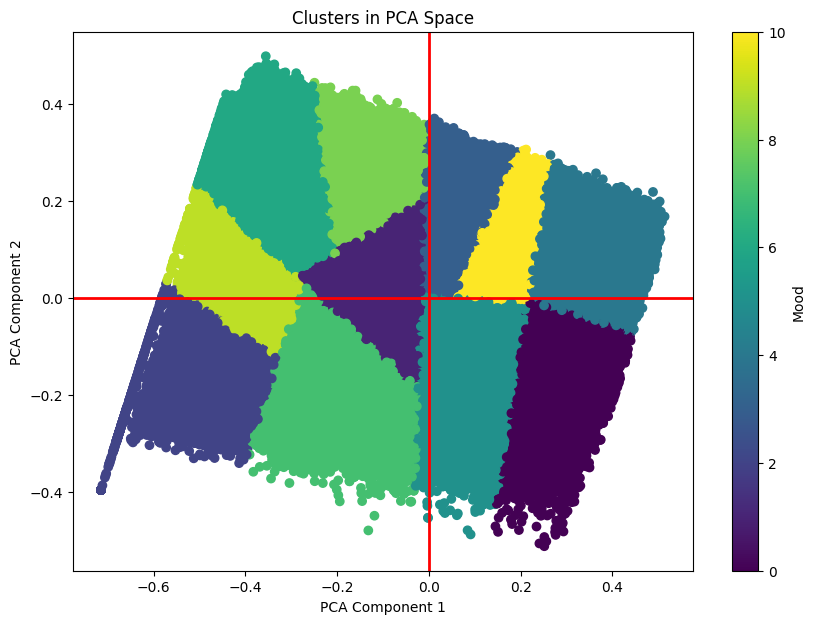

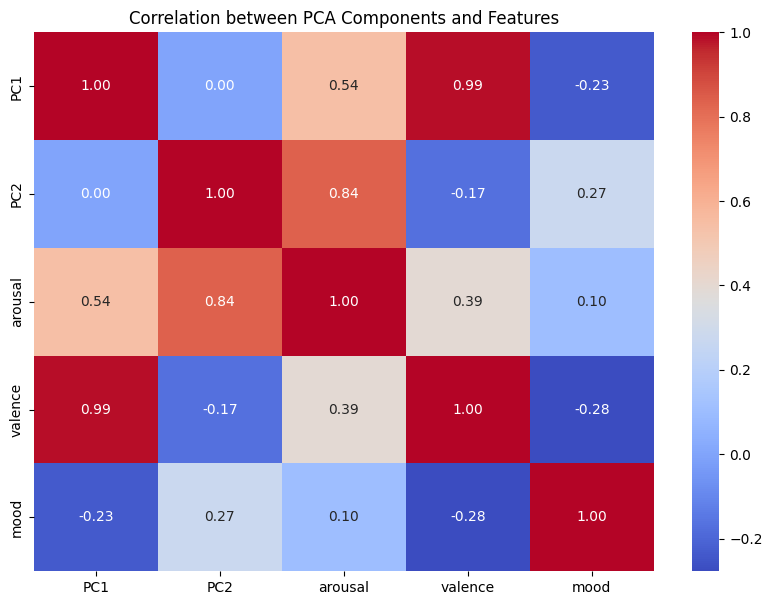

Completed K-Means for k=11 in 48.65 seconds


Running K-Means for k=12


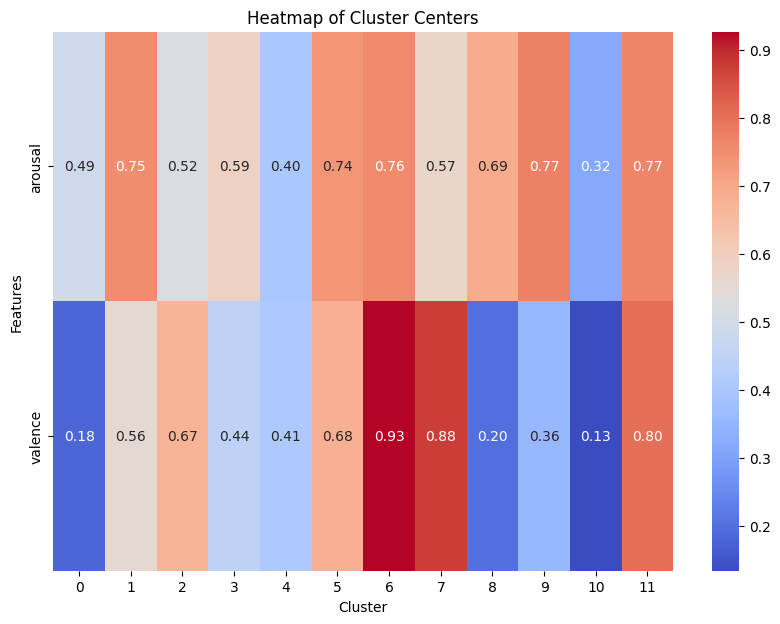

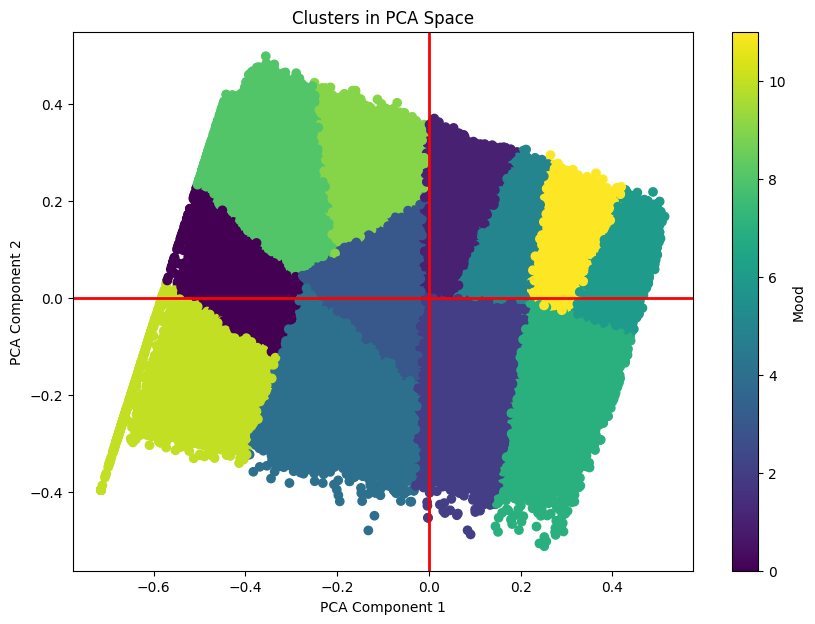

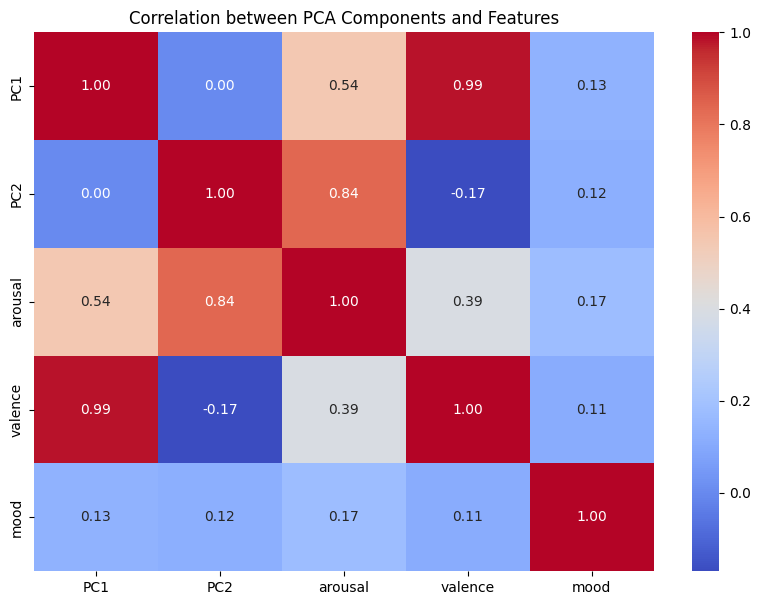

Completed K-Means for k=12 in 42.70 seconds


Running K-Means for k=13


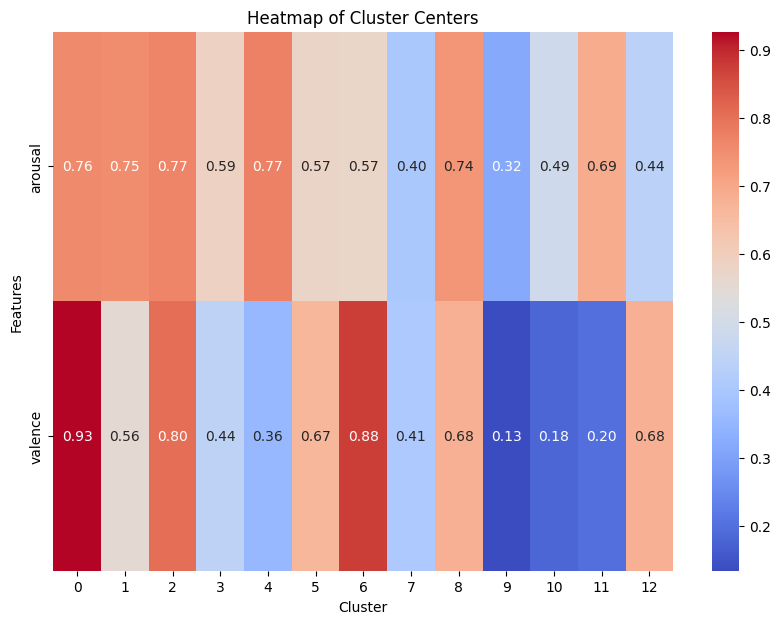

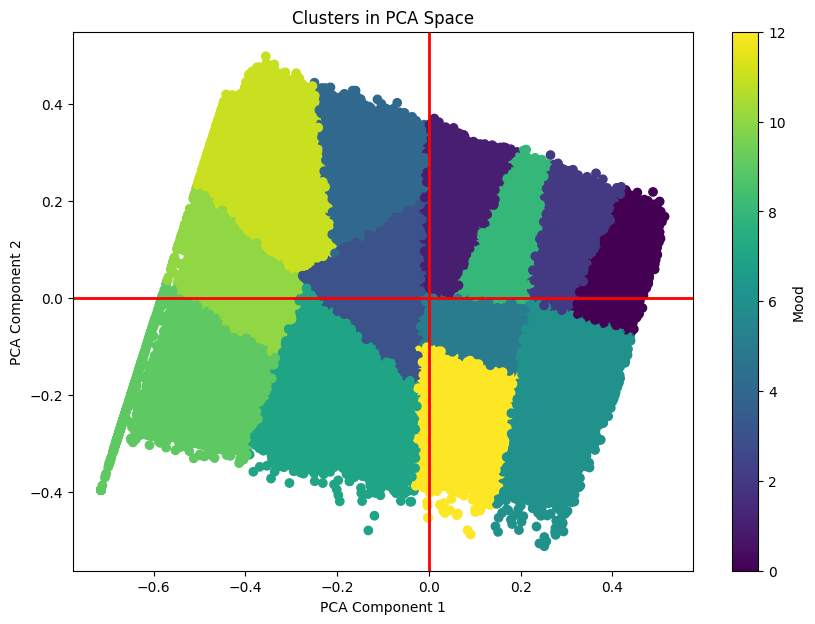

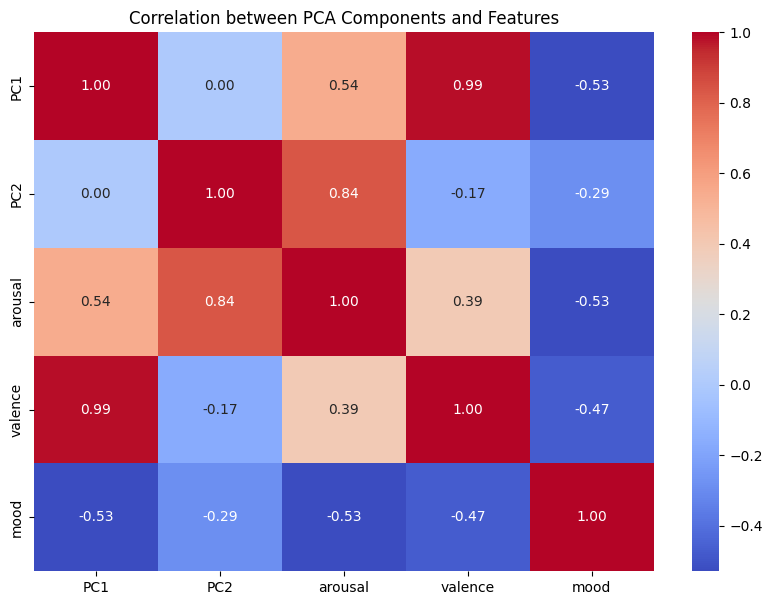

Completed K-Means for k=13 in 46.02 seconds


Running K-Means for k=14


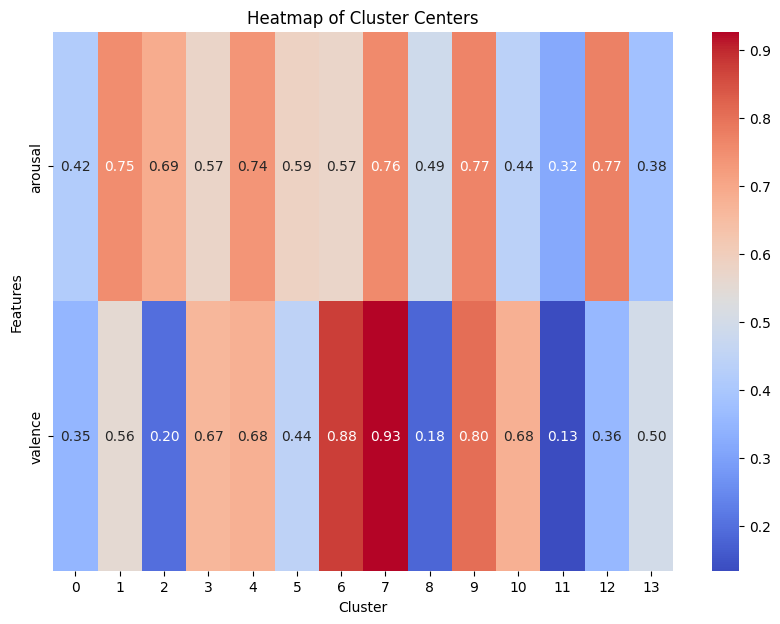

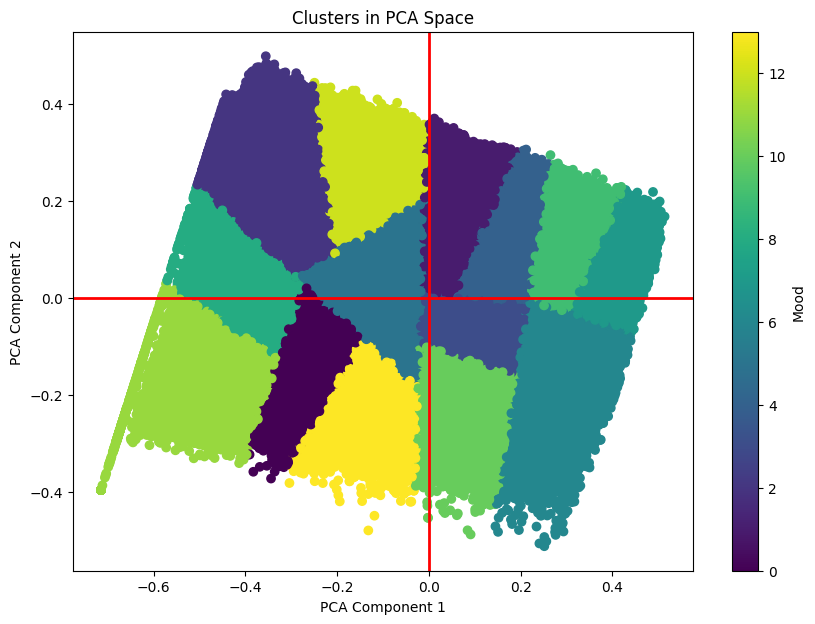

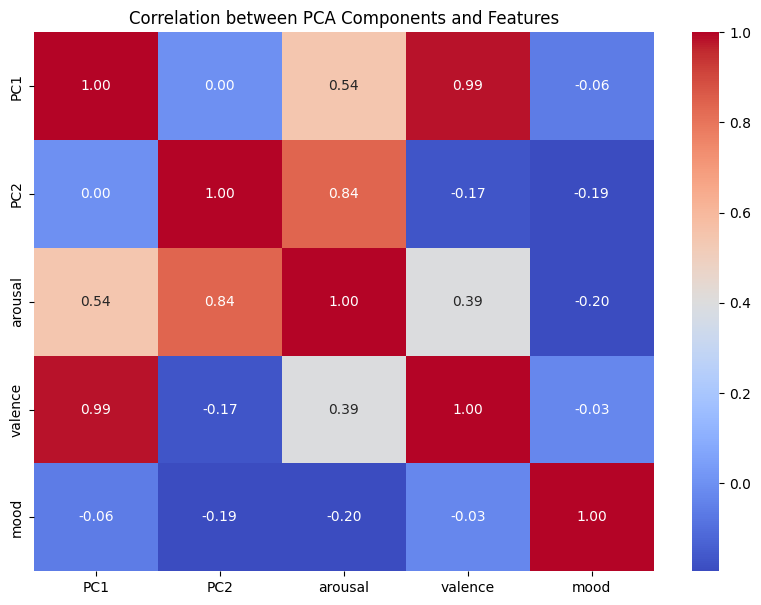

Completed K-Means for k=14 in 50.36 seconds


Running K-Means for k=15


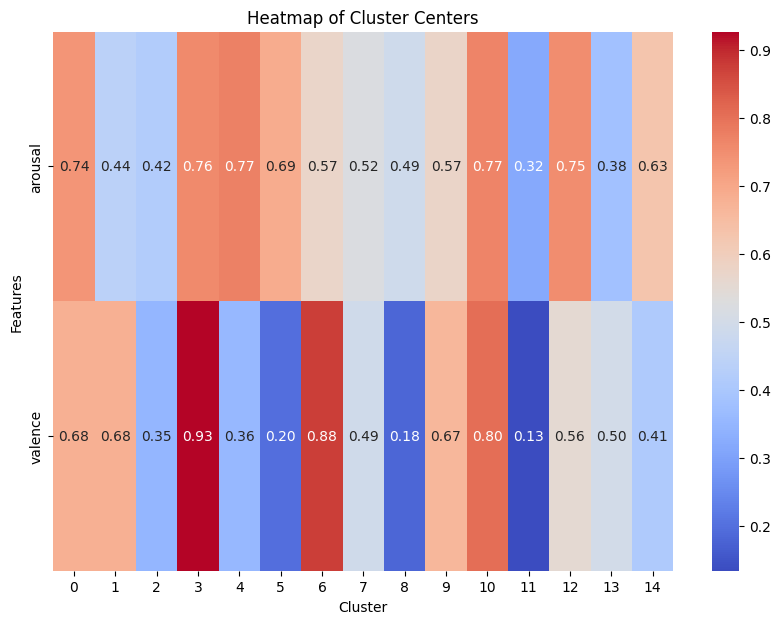

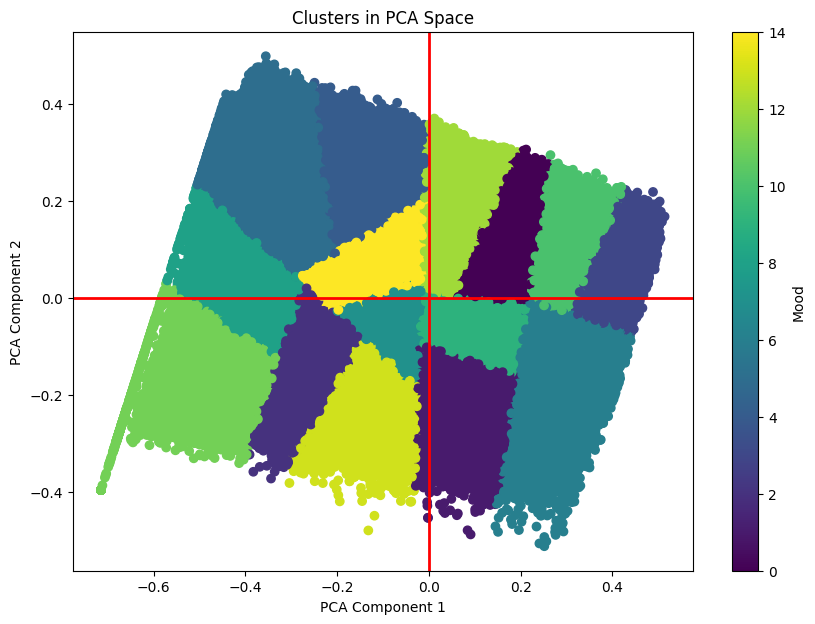

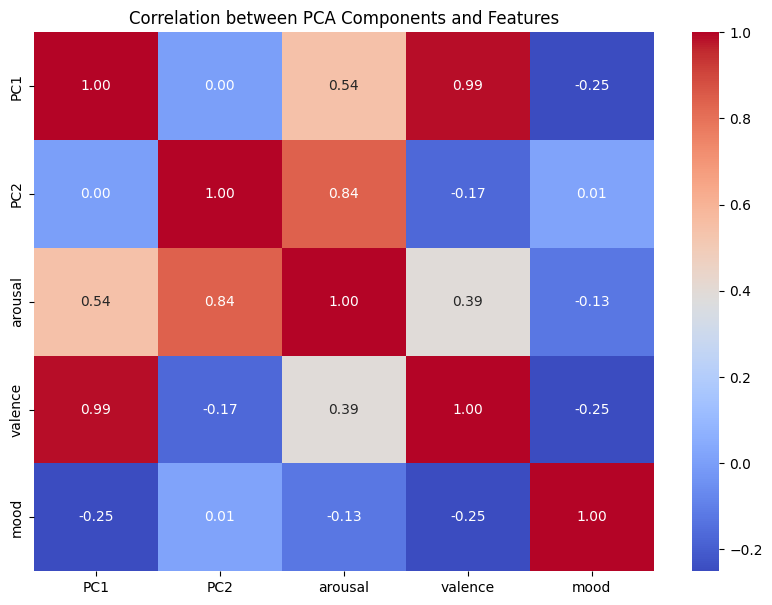

Completed K-Means for k=15 in 52.05 seconds


Running K-Means for k=16


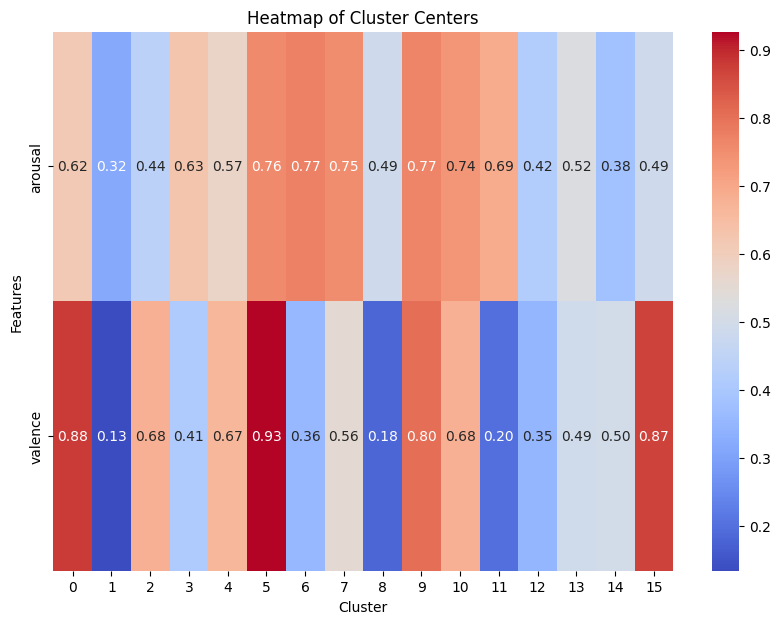

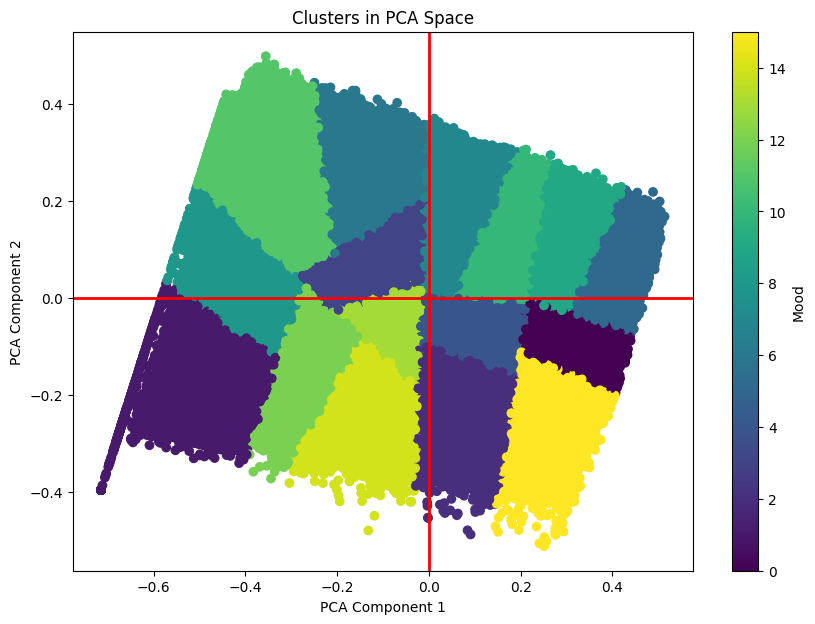

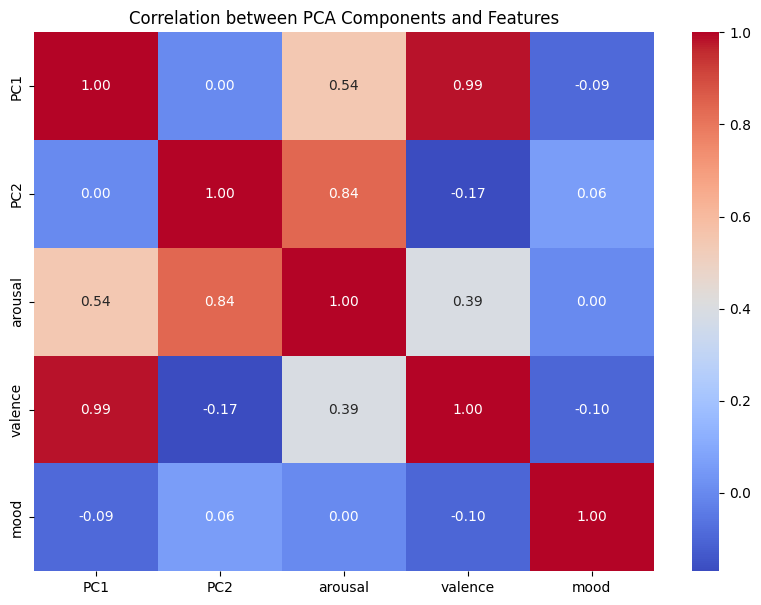

Completed K-Means for k=16 in 47.41 seconds



In [4]:
data_scaled_for_kmeans = joblib.load(data_scaled_pkl)

num_rows, num_columns = data_scaled_for_kmeans.shape
sample_sil = round((num_rows-1)*0.05) #5% Dataset

wcss_results = []
sil_results = []
ch_results = []
db_results = []

k_range = range(2, 17)
print(f"Running Kmeans k = {list(k_range)} Clusters")
for k in k_range:
    print(f"\nRunning K-Means for k={k}")
    start_time = time.time()

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit_predict(data_scaled_for_kmeans)

    wcss_results.append(kmeans.inertia_)
    sil_score = silhouette_score(
        data_scaled_for_kmeans,
        kmeans.labels_,
        metric='euclidean',
        sample_size=sample_sil, 
        random_state=42,
        n_jobs=-1
    )
    sil_results.append(sil_score)
    ch_score = calinski_harabasz_score(data_scaled_for_kmeans, kmeans.labels_)
    ch_results.append(ch_score)
    db_score = davies_bouldin_score(data_scaled_for_kmeans, kmeans.labels_)
    db_results.append(db_score)

    data_scaled_for_kmeans['mood'] = kmeans.labels_

    # 1. Plotting the heatmap of the clusters first (based on mood)
    plt.figure(figsize=(10, 7))
    sns.heatmap(data_scaled_for_kmeans.groupby('mood').mean().T, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Heatmap of Cluster Centers')
    plt.ylabel('Features')
    plt.xlabel('Cluster')
    plt.show()

    # 2. Plotting the clusters in PCA space (after the heatmap)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data_scaled_for_kmeans[['arousal','valence']])
    plt.figure(figsize=(10, 7))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=data_scaled_for_kmeans['mood'], cmap='viridis')
    plt.title('Clusters in PCA Space')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.axhline(0, color='r', linewidth=2)
    plt.axvline(0, color='r', linewidth=2)
    plt.colorbar(label='Mood')
    plt.show()

    # 3. Plotting the heatmap of the correlation between PCA components and features
    pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
    pca_df = pd.concat([pca_df, data_scaled_for_kmeans], axis=1)
    correlation_matrix = pca_df.corr()
    plt.figure(figsize=(10, 7))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation between PCA Components and Features")
    plt.show()

    print(f"Completed K-Means for k={k} in {time.time() - start_time:.2f} seconds\n")

# Print the results
results_kmeans = pd.DataFrame({
    'k': list(k_range),
    'WCSS': wcss_results,
    'Silhouette Score': sil_results,
    'Calinski-Harabasz': ch_results,
    'Davies-Bouldin': db_results
})

# Resultados para la eleccion del numeor de cluster ideal


 k        WCSS  Silhouette Score  Calinski-Harabasz  Davies-Bouldin
 2 22948.25530           0.47110       7.749034e+05         0.79710
 3 18103.24875           0.59077       2.932109e+06         0.83923
 4 13882.30692           0.56989       6.202162e+06         0.69558
 5 11764.72656           0.72109       9.446111e+06         0.46523
 6  9798.55768           0.75668       1.154170e+07         0.43479
 7  8097.78010           0.75359       1.686951e+07         0.41745
 8  6758.19787           0.75005       2.505302e+07         0.37402
 9  6176.39729           0.81947       3.675649e+07         0.34314
10  5660.05924           0.82761       4.132296e+07         0.34136
11  5309.59823           0.80307       4.588373e+07         0.34236
12  4975.88168           0.81588       6.057955e+07         0.30259
13  4650.34048           0.83198       6.544299e+07         0.29288
14  4325.44388           0.85308       7.574916e+07         0.25887
15  4013.00292           0.83745       8.082351

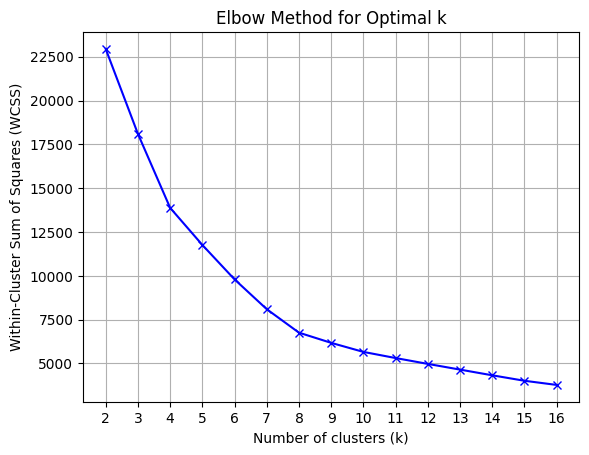

In [5]:
# Print Results of the Kmeans
print(f"\n{results_kmeans.round(5).to_string(index=False)}\n")

# Find the best k for each metric
best_k_wcss = results_kmeans.loc[results_kmeans['WCSS'].idxmin()]['k']
best_k_silhouette = results_kmeans.loc[results_kmeans['Silhouette Score'].idxmax()]['k']
best_k_calinski = results_kmeans.loc[results_kmeans['Calinski-Harabasz'].idxmax()]['k']
best_k_davies = results_kmeans.loc[results_kmeans['Davies-Bouldin'].idxmin()]['k']
best_k_knee = KneeLocator(list(k_range), wcss_results, curve='convex', direction='decreasing',S=1)

# Print the results
print(f"Best k based on WCSS: k = {best_k_wcss}")
print(f"Best k based on Silhouette Score: k = {best_k_silhouette}")
print(f"Best k based on Calinski-Harabasz: k = {best_k_calinski}")
print(f"Best k based on Davies-Bouldin: k = {best_k_davies}")
print(f"Best k based on KneeLocator: k = {best_k_knee.knee}")

# Plotting the Elbow Method
plt.plot(list(k_range), wcss_results, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid()

# Display the plot
plt.show()

# Correr el Kmeans con el numero de clusters elejidos

In [13]:
# El numero de cluster elejido
selectedClustersNumber = 4

# Run Kmeans Clustering for selected cluster number
def train_kmeans(k_in: int, scaled_input_pkl: str, scaled_labeled_output_pkl: str, model_output_pkl: str):

    start_time = time.time()

    print(f"K-means Training (Get Clusters)")

    data_scaled = joblib.load(scaled_input_pkl)
    kmeans = KMeans(n_clusters=k_in, random_state=42, n_init=10)
    data_scaled['mood'] = kmeans.fit_predict(data_scaled)

    joblib.dump(kmeans, model_output_pkl)
    joblib.dump(data_scaled, scaled_labeled_output_pkl)

    print(f"Model saved to: {model_output_pkl}")
    print(f"Scaled labeled data saved to: {scaled_labeled_output_pkl}")
    print(f"Completed in {time.time() - start_time:.2f} seconds\n\n")

train_kmeans(selectedClustersNumber, data_scaled_pkl, data_scaled_labeled_pkl, model_kmeans_pkl)

K-means Training (Get Clusters)
Model saved to: ./Models/model_kmeans.pkl
Scaled labeled data saved to: ./Data/data_scaled_labeled.pkl
Completed in 3.32 seconds




# Separar el dataset en Train y Test

In [16]:
# Save Train and Test Vectors
def save_train_and_test_data(scaled_labeled_input_pkl: str, train_data_pkl: str, test_data_pkl: str):

    start_time = time.time()

    print("Splitting and saving train/test data")

    df = joblib.load(scaled_labeled_input_pkl)
    x = df.drop(columns=["mood"])
    y = df["mood"]

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y
    )

    joblib.dump((x_train, y_train), train_data_pkl)
    joblib.dump((x_test, y_test), test_data_pkl)

    print(f"Train data saved to: {train_data_pkl}")
    print(f"Test data saved to: {test_data_pkl}")
    print(f"Completed in {time.time() - start_time:.2f} seconds\n\n")

save_train_and_test_data(data_scaled_labeled_pkl, data_train_pkl, data_test_pkl)

Splitting and saving train/test data
Train data saved to: ./Data/data_train.pkl
Test data saved to: ./Data/data_test.pkl
Completed in 0.63 seconds


